In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
from torchvision.datasets import ImageFolder
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

/Users/nikoletaulama/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Resize the images

In [3]:
def resize_transformation(img):
    resize = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor(), transforms.Grayscale()])
    i = resize(img)
    i = i * 255.0  # back to 0-255
    return i

Import datasets

In [4]:
train_dataset = ImageFolder(root="../train", transform=resize_transformation)
test_dataset = ImageFolder(root="../test", transform=resize_transformation)

Split the training set in 85% for actual training set and 15% to be used as validation set

In [5]:
train_size = int(0.85 * len(train_dataset))
validation_size = len(train_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

In [6]:
class Augmentation:

    def __init__(self, ds):
        self.ds = ds
        self.transformation = transforms.RandomHorizontalFlip(1)

    def __getitem__(self, index):
        img, label = self.ds[index]

        if self.transformation:
            img = self.transformation(img)

        return img, label

    def __len__(self):
        return len(self.ds)

Minibatches of size 32; 
Apply augmentation

In [7]:
batch_size = 32
augmented_training_set = Augmentation(training_set)
concatenated_dataset = torch.utils.data.ConcatDataset([training_set, augmented_training_set])
augmented_train_loader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Network layout

In [8]:
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=7, padding=3)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 16 * 16, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Initial bias and initial weights

In [9]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)

In [10]:
model = simpleCNN()
model.apply(init_weights)

simpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
)

Employ the stochastic gradient descent with momentum optimization algorithm

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Training and Validation

In [12]:
epochs = 30

best_validation_loss = np.inf
train_losses = []
validation_losses = []
validation_accuracies = []
train_accuracies = []
for epoch in range(epochs):
    print("EPOCH {}:".format(epoch + 1))

    model.train(True)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, data in enumerate(augmented_train_loader):

        input, labels = data  

        outputs = model(input)  

        loss = loss_function(outputs, labels) 
        running_loss += (loss.item())  

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

    train_loss = running_loss / (i + 1) 
    train_accuracy = correct_predictions / total_samples

    running_validation_loss = 0.0
    
    model.eval()

    with torch.no_grad(): 
        correct = 0
        total = 0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_function(voutputs, vlabels)
            running_validation_loss += vloss
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = running_validation_loss / (i + 1)  
    validation_acc = 100 * correct / total

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_acc)
    train_accuracies.append(train_accuracy)

    print("LOSS train {} validation {}".format(train_loss, validation_loss))
    print(f"LOSS train: {train_loss} validation: {validation_loss} | validation_accuracy: {validation_acc}% ")

    if validation_loss < best_validation_loss:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        best_validation_loss = validation_loss
        model_path = "model_{}_{}".format(timestamp, epoch)
        torch.save(model.state_dict(), model_path)

model.load_state_dict(torch.load(model_path))

EPOCH 1:
LOSS train 3.3695443853735925 validation 2.395752429962158
LOSS train: 3.3695443853735925 validation: 2.395752429962158 | validation_accuracy: 36.36363636363637% 
EPOCH 2:
LOSS train 1.9715591311454772 validation 2.793886184692383
LOSS train: 1.9715591311454772 validation: 2.793886184692383 | validation_accuracy: 31.818181818181817% 
EPOCH 3:
LOSS train 1.5452325329184533 validation 1.9374988079071045
LOSS train: 1.5452325329184533 validation: 1.9374988079071045 | validation_accuracy: 36.36363636363637% 
EPOCH 4:
LOSS train 1.3019196532666684 validation 3.628185510635376
LOSS train: 1.3019196532666684 validation: 3.628185510635376 | validation_accuracy: 50.0% 
EPOCH 5:
LOSS train 1.0901623480021954 validation 2.0799107551574707
LOSS train: 1.0901623480021954 validation: 2.0799107551574707 | validation_accuracy: 77.27272727272727% 
EPOCH 6:
LOSS train 0.8588404979556798 validation 3.625476837158203
LOSS train: 0.8588404979556798 validation: 3.625476837158203 | validation_accura

<All keys matched successfully>

Training and Validation Metrics

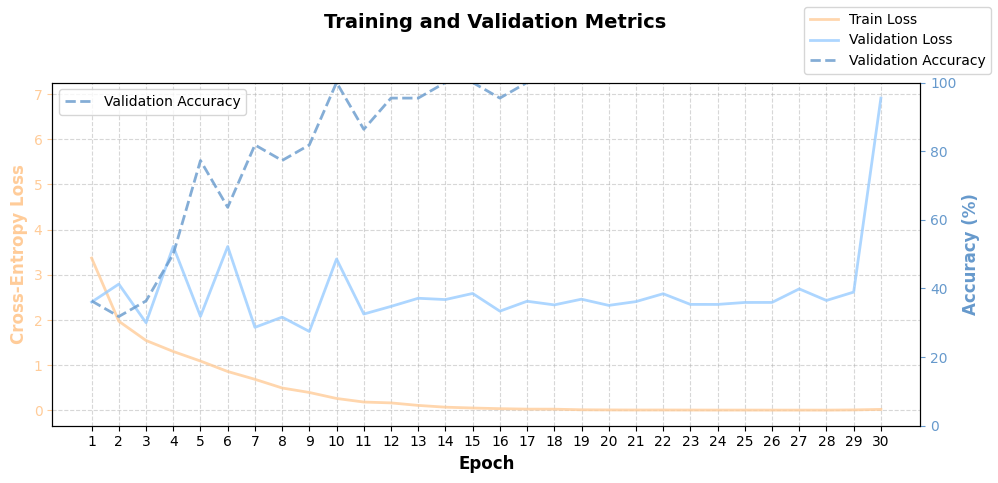

In [13]:
pastel_orange = (1.0, 0.8, 0.6)
pastel_blue = (0.6, 0.8, 1.0, 1.0) 
pastel_dark_blue = (0.4, 0.6, 0.8, 1.0)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  

ax1.plot(train_losses, color=pastel_orange, linewidth=2, label="Train Loss", alpha=0.8)
validation_losses_np = torch.stack(validation_losses).cpu().numpy()
ax1.plot(
    validation_losses_np,
    color=pastel_blue,
    linewidth=2,
    label="Validation Loss",
    alpha=0.8,
)

ax1.set_xlabel("Epoch", fontsize=12, fontweight="bold")
ax1.set_ylabel("Cross-Entropy Loss", fontsize=12, fontweight="bold", color=pastel_orange)
ax1.tick_params(axis="y", colors=pastel_orange)
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.set_xticks(range(len(train_losses)))  
ax1.set_xticklabels(range(1, len(train_losses) + 1))  
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

ax2.plot(
    validation_accuracies,
    color=pastel_dark_blue,
    linestyle="--",
    linewidth=2,
    label="Validation Accuracy",
    alpha=0.8,
)

ax2.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold", color=pastel_dark_blue)
ax2.tick_params(axis="y", colors=pastel_dark_blue)
ax2.set_ylim(0, 100)  
ax2.legend(loc="upper left", fontsize=10)

fig.legend(loc="upper right", fontsize=10)
fig.set_size_inches(10, 5)

fig.suptitle("Training and Validation Metrics", fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Test and Accuracy

In [14]:
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)  
        y_true.extend(labels)  

print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")

Accuracy of the network on the test images: 50.22%


Confusion matrix

<Axes: >

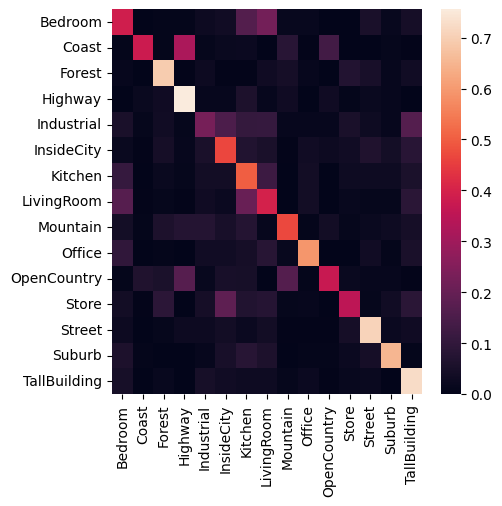

In [15]:
classes = test_dataset.classes
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
    index=[i for i in classes],
    columns=[i for i in classes],
)
plt.figure(figsize=(5, 5))
sn.heatmap(df_cm)